In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Load and prepare MNIST data

In [11]:
transform = transforms.Compose([transforms.ToTensor()])

In [12]:
train_dataset_full = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
test_dataset = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

In [13]:
train_size = 50000
val_size = len(train_dataset_full) - train_size
training_dataset, validation_dataset = random_split(train_dataset_full, [train_size, val_size])

In [14]:
train_loader = DataLoader(training_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Define a flexible NN model

In [16]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128, 128, 128], output_size=10):
        super().__init__()
        layers = []
        in_features = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_features, h))
            layers.append(nn.ReLU())
            in_features = h
        layers.append(nn.Linear(in_features, output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # Flatten the image tensor [batch_size, 1, 28, 28] -> [batch_size, 784]
        x = x.view(x.size(0), -1)
        return self.net(x)

# 3. Training function

In [17]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(100 * correct / total)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(100 * val_correct / val_total)

    return train_losses, val_losses, train_accs, val_accs

In [18]:
# Prepare flattened numpy arrays for logistic/softmax models
train_X = training_dataset.dataset.data.numpy().reshape(-1, 28*28)[:len(training_dataset)]
train_y = training_dataset.dataset.targets.numpy()[:len(training_dataset)]
test_X = test_dataset.data.numpy().reshape(-1, 28*28)
test_y = test_dataset.targets.numpy()

In [19]:
# Scale the data for faster convergence
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

# 4. Comparative Analysis
# Compare Logistic Regression, Softmax Regression, and the Best Neural Network.

In [20]:
comparison_summary = []

# Logistic Regression

In [21]:
start = time()
log_reg = LogisticRegression(max_iter=500, solver='lbfgs')
log_reg.fit(train_X_scaled, train_y)
test_acc = log_reg.score(test_X_scaled, test_y) * 100
comparison_summary.append(("Logistic Regression", round(test_acc, 2), round(time()-start, 2)))

# Softmax Regression

In [22]:
start = time()
softmax_reg = LogisticRegression(max_iter=500, solver='lbfgs')
softmax_reg.fit(train_X_scaled, train_y)
test_acc = softmax_reg.score(test_X_scaled, test_y) * 100
comparison_summary.append(("Softmax Regression", round(test_acc, 2), round(time()-start, 2)))

# Neural Network (Best configuration)

In [23]:
best_nn = FeedforwardNN(hidden_sizes=[128,128,128]).to(device)
optimizer = optim.SGD(best_nn.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
start = time()
train_model(best_nn, train_loader, val_loader, optimizer, criterion, epochs=10)
elapsed = time() - start

# Test evaluation

In [24]:
best_nn.eval()
correct, total = 0, 0
preds_list, labels_list = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_nn(images)
        _, preds = torch.max(outputs, 1)
        preds_list.extend(preds.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())
        correct += (preds == labels).sum().item()
        total += labels.size(0)
test_acc = 100 * correct / total
comparison_summary.append(("Neural Network (3x128)", round(test_acc,2), round(elapsed,2)))

In [25]:
# Summary table
comparison_df = pd.DataFrame(comparison_summary, columns=["Model", "Test Accuracy (%)", "Training Time (s)"])
print("\n=== Model Comparison Summary ===")
print(comparison_df)


=== Model Comparison Summary ===
                    Model  Test Accuracy (%)  Training Time (s)
0     Logistic Regression              91.98               9.68
1      Softmax Regression              91.98               9.02
2  Neural Network (3x128)              93.48              34.82


## 5. Confusion Matrix and Misclassification Analysis (Best Neural Network)

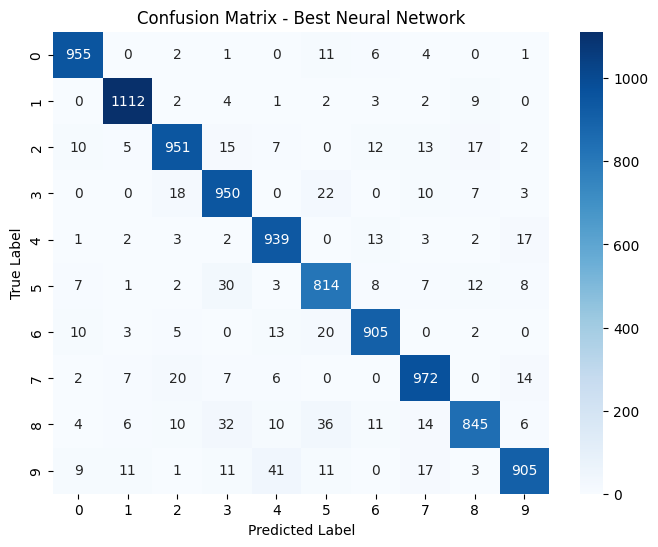

In [26]:
cm = confusion_matrix(labels_list, preds_list)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Best Neural Network")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

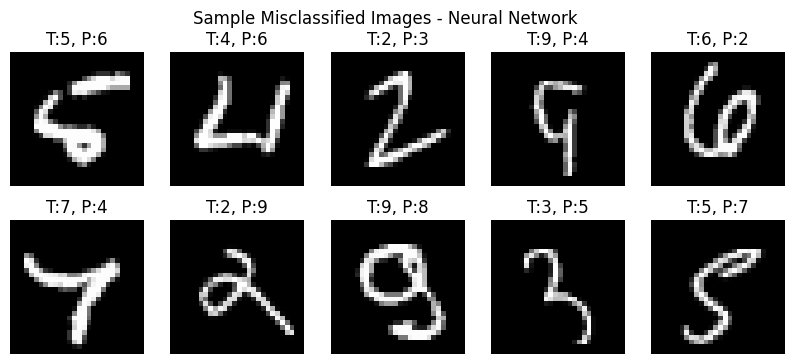

In [27]:
# Show some misclassified samples
misclassified_indices = [i for i, (p, t) in enumerate(zip(preds_list, labels_list)) if p != t]
plt.figure(figsize=(10, 4))
for i, idx in enumerate(misclassified_indices[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_dataset.data[idx], cmap='gray')
    plt.title(f"T:{labels_list[idx]}, P:{preds_list[idx]}")
    plt.axis('off')
plt.suptitle("Sample Misclassified Images - Neural Network")
plt.show()